**BEFORE WE START**: Make sure that any open notebooks that are no longer needed are shut down to free up compute resources (note that closing the tab is not enough!). This will reduce the risk of running into memory and/or performance issues.

# Activity recognition on the Capture-24 dataset

<img src="wrist_accelerometer.jpg" width="300"/>

The Capture-24 dataset contains wrist-worn accelerometer data
collected from 151 participants. To obtain ground truth annotations, the
participants also wore a body camera during daytime, and used sleep diaries to
register their sleep times. Each participant was recorded for roughly 24 hours.
The accelerometer was an Axivity AX3 wrist watch (image above) that mearures
acceleration in all three axes (x, y, z) at a sampling rate of 100Hz.
The body camera was a Vicon Autographer with a sampling rate of 1 picture every 20 seconds.
Note that the camera images are not part of the data release &mdash; only the
raw acceleration trace with text annotations are provided.

## Setup

In [2]:
import os
from glob import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.ensemble import BalancedRandomForestClassifier
from sklearn import decomposition
from sklearn import preprocessing
from sklearn import manifold
from sklearn import metrics
from tqdm.auto import tqdm
from joblib import Parallel, delayed
import urllib.request
import shutil
import zipfile

import utils

pd.options.display.max_rows = 999
pd.options.display.max_colwidth = None

# For reproducibility
np.random.seed(42)
N_JOBS = 2

## Download dataset
Download the required dataset from https://ora.ox.ac.uk/objects/uuid:99d7c092-d865-4a19-b096-cc16440cd001 then unzip and copy the folder into the current directory.

Alternatively, run the cell below:

In [3]:
# NOTE: The required dataset is already available at /srv/capture24.
# The following creates a symbolic link (shortcut in Windows) to it in the current directory.
if not os.path.exists("capture24"):
    os.symlink("/srv/capture24", "capture24")

# If you really want to download the dataset, uncomment and run the following code (note that this will take a while):
# print(f"Downloading Capture-24...")
# url = "https://ora.ox.ac.uk/objects/uuid:99d7c092-d865-4a19-b096-cc16440cd001/download_file?file_format=&safe_filename=capture24.zip&type_of_work=Dataset"
# with urllib.request.urlopen(url) as f_src, open("capture24.zip", "wb") as f_dst:
#     shutil.copyfileobj(f_src, f_dst)
# print("Unzipping...")
# with zipfile.ZipFile("capture24.zip", "r") as f:
#     f.extractall(".")

Once this data is downwloaded, we can print out its content:

In [4]:
print(f'Content of capture24/')
print(os.listdir("capture24/"))

Content of capture24/
['P056.csv.gz', 'P006.csv.gz', 'P022.csv.gz', 'P122.csv.gz', 'P027.csv.gz', 'P092.csv.gz', 'P084.csv.gz', 'P121.csv.gz', 'P148.csv.gz', 'P025.csv.gz', 'P144.csv.gz', 'P088.csv.gz', 'P023.csv.gz', 'P120.csv.gz', 'P103.csv.gz', 'P062.csv.gz', 'P030.csv.gz', 'P099.csv.gz', 'P021.csv.gz', 'P059.csv.gz', 'P034.csv.gz', 'P070.csv.gz', 'P086.csv.gz', 'P111.csv.gz', 'P142.csv.gz', 'P039.csv.gz', 'P069.csv.gz', 'P131.csv.gz', 'P066.csv.gz', 'P019.csv.gz', 'P076.csv.gz', 'P048.csv.gz', 'P089.csv.gz', 'P037.csv.gz', 'P109.csv.gz', 'P146.csv.gz', 'P035.csv.gz', 'P104.csv.gz', 'P016.csv.gz', 'P052.csv.gz', 'P042.csv.gz', 'P091.csv.gz', 'P073.csv.gz', 'P050.csv.gz', 'P112.csv.gz', 'P057.csv.gz', 'P036.csv.gz', 'P138.csv.gz', 'P116.csv.gz', 'P105.csv.gz', 'P065.csv.gz', 'P114.csv.gz', 'P008.csv.gz', 'P113.csv.gz', 'P106.csv.gz', 'P129.csv.gz', 'P079.csv.gz', 'P044.csv.gz', 'P150.csv.gz', 'P055.csv.gz', 'P063.csv.gz', 'P095.csv.gz', 'P107.csv.gz', 'P068.csv.gz', 'P130.csv.gz', 'P

**Exercise 1**: How many participants are in this dataset?

## Load data

First, let's load the accelerometry data for a single particpant

In [5]:
data = utils.load_data('capture24/P001.csv.gz')
print('\nParticipant P001:')
print(data)


Participant P001:
                                x         y         z              annotation
time                                                                         
2016-11-13 02:18:00.000 -0.466690 -0.533341  0.658472  7030 sleeping;MET 0.95
2016-11-13 02:18:00.010 -0.466690 -0.533341  0.658472  7030 sleeping;MET 0.95
2016-11-13 02:18:00.020 -0.466690 -0.533341  0.658472  7030 sleeping;MET 0.95
2016-11-13 02:18:00.030 -0.466690 -0.533341  0.658472  7030 sleeping;MET 0.95
2016-11-13 02:18:00.040 -0.466690 -0.533341  0.658472  7030 sleeping;MET 0.95
...                           ...       ...       ...                     ...
2016-11-14 06:07:59.960  0.049416 -0.797846  0.565700  7030 sleeping;MET 0.95
2016-11-14 06:07:59.970  0.049416 -0.782285  0.565700  7030 sleeping;MET 0.95
2016-11-14 06:07:59.980  0.049416 -0.782285  0.565700  7030 sleeping;MET 0.95
2016-11-14 06:07:59.990  0.049416 -0.782285  0.565700  7030 sleeping;MET 0.95
2016-11-14 06:08:00.000  0.049416 -0.782285  

**Exercise 2**: What do columns `x`, `y`, `z` mean? Can you guess the units? Hint: sqrt(x^2 + y^2 + z^2) = ?

**Exercise 3**: How many hours of useable data did participant `P001` provide?

Let's see the list of different activities performed by P001

In [6]:
print("\nList of unique activities by participant P001")
print(data['annotation'].unique())


List of unique activities by participant P001
<StringArray>
[                                                                                                                                                                         '7030 sleeping;MET 0.95',
                                                                                                                                                                                              <NA>,
                                                                                                                                       'home activity;self care;13020 dressing/undressing;MET 2.5',
                                                                                                    'home activity;miscellaneous;walking;17150 walking household without observable loads;MET 2.0',
                                                  'home activity;household chores;preparing meals/cooking/washing dishes;5035 kitchen activity general cook

**Exercise 4**: How many unique activities are in `P001`?

The annotations are based on the [Compendium of Physical
Activity](https://sites.google.com/site/compendiumofphysicalactivities/home) (CPA).
The leading numbers in the annotations are CPA codes used to uniquely identify different human
activities, e.g. "7030 sleeping", "11580 office work such as writing and
typing". The trailing numbers indicate metabolic equivalent of task (MET).
These numbers will not be important for now.

In the Capture-24 dataset, more than 200 distinct annotations were collected
across all participants.

To develop a model for activity recognition, let's segment the data into windows of
30 seconds. 

The activity recognition model will then be trained to classify the
individual windows.

In [7]:
X, Y, T = utils.make_windows(data, winsec=30)
print("X shape:", X.shape)
print("Y shape:", Y.shape)
print("T shape:", T.shape)

X shape: (2491, 3000, 3)
Y shape: (2491,)
T shape: (2491,)


**Exercise 5**: Why is the shape of array `X` (N, 3000, 3)? What does each number mean?

As mentioned, there can be hundreds of distinct annotations, many of which are
physically very similar (e.g. "sitting, child care", "sitting, pet care").
For our purposes, it is enough to map these annotations onto a simpler
set of labels. The provided file *annotation-label-dictionary.csv*
contains different annotation-to-label mappings that can be used.
We will summarise the different annotations into 6 activity classes:
"sleep", "sit-stand", "vehicle", "walking", "bicycling", and "mixed".

**Exercise 6**: Open the *annotation-label-dictionary.csv* file in Excel or any
other spreadsheet app. What other mappings (e.g. "label:Walmsley2020") are there?

In [8]:
anno_label_dict = pd.read_csv(
    "capture24/annotation-label-dictionary.csv", 
    index_col='annotation', 
    dtype='string'
)

# Map annotations using Willetts' labels  (see paper reference at the bottom)
Y = anno_label_dict.loc[Y, 'label:Willetts2018'].to_numpy()

Let's count the number of 30-sec windows for each activity class.
For this participant, we only observe 5 classes (no "bicycling").

In [9]:
print('\nLabel distribution (# windows)')
print(pd.Series(Y).value_counts())


Label distribution (# windows)
sleep        914
sit-stand    708
mixed        476
vehicle      201
walking      192
Name: count, dtype: int64


**Exercise 7**: How many hours of `sit-stand` do we have for `P001`?


# Visualization
Visualization helps us get some insight and anticipate the difficulties that
may arise during the modelling.
Let's visualize some examples for each activity label.


Run the below script multiple times to draw new samples

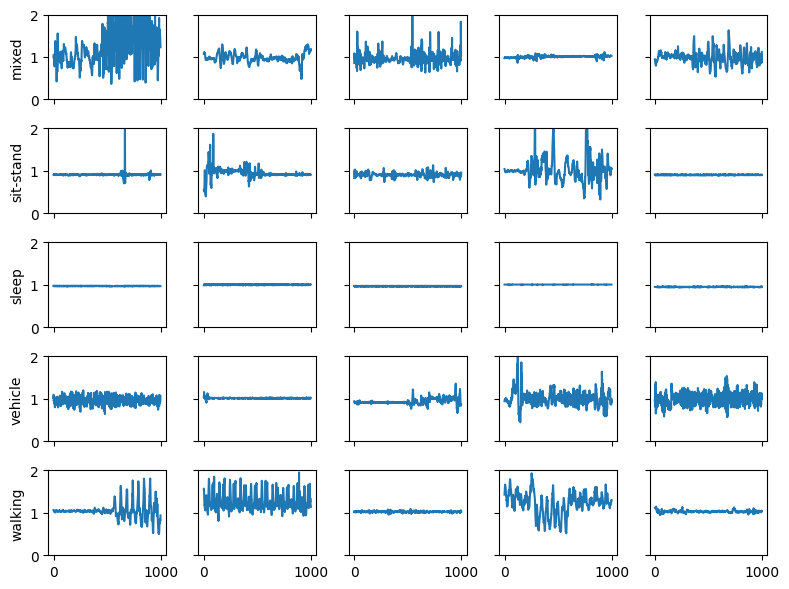

In [16]:
np.random.seed(234)
NPLOTS = 5
unqY = np.unique(Y)
fig, axs = plt.subplots(len(unqY), NPLOTS, sharex=True, sharey=True, figsize=(8,6))
for y, row in zip(unqY, axs):
    idxs = np.random.choice(np.where(Y==y)[0], size=NPLOTS)
    row[0].set_ylabel(y)
    for x, ax in zip(X[idxs], row):
        ax.plot(np.linalg.norm(x[:1000], axis=-1))
        ax.set_ylim(0,2)
fig.tight_layout()
fig.show()

From the plots, we can already tell it should be easier to classify "sleep"
and maybe "sit-stand", with the signal variance being a good discriminative
feature for this.
Next, let's try to visualize the data in a scatter-plot.
The most standard approach to visualize high-dimensional points is to
scatter-plot the first two principal components of the data.

## PCA visualization


In [ ]:
def scatter_plot(X, Y):
    unqY = np.unique(Y)
    fig, ax = plt.subplots()
    for y in unqY:
        X_y = X[Y==y]
        ax.scatter(X_y[:,0], X_y[:,1], label=y, alpha=.5, s=10)
    fig.legend()
    fig.show()

print("Plotting first two PCA components...")
scaler = preprocessing.StandardScaler()  # PCA requires normalized data
X_scaled = scaler.fit_transform(X.reshape(X.shape[0],-1))
pca = decomposition.PCA(n_components=2)  # two components
X_pca = pca.fit_transform(X_scaled)
scatter_plot(X_pca, Y)

## t-SNE visualization
PCA's main limitation is in dealing with data that is not linearly separable.
Another popular high-dimensional data visualization tool is _t-distributed
stochastic neighbor embedding_ (t-SNE).  Let's first use it on top of PCA to
visualize 50 principal components.

*Note: this may take a while*

In [ ]:
print("Plotting t-SNE on 50 PCA components...")
pca = decomposition.PCA(n_components=50)
X_pca = pca.fit_transform(X_scaled)
tsne = manifold.TSNE(n_components=2,  # project down to 2 components
    init='random', random_state=42, perplexity=100, learning_rate='auto')
X_tsne_pca = tsne.fit_transform(X_pca)
scatter_plot(X_tsne_pca, Y)

# Feature extraction
Let's extract a few signal features for each window.

In [ ]:
def extract_features(xyz):
    ''' Extract features. xyz is an array of shape (N,3) '''

    feats = {}
    feats['xMean'], feats['yMean'], feats['zMean'] = np.mean(xyz, axis=0)
    feats['xStd'], feats['yStd'], feats['zStd'] = np.std(xyz, axis=0)
    v = np.linalg.norm(xyz, axis=1)  # magnitude stream
    feats['mean'], feats['std'] = np.mean(v), np.std(v)

    return feats

X_feats = pd.DataFrame([extract_features(x) for x in tqdm(X)])
print(X_feats)

**Exercise 8**: Edit the function above to implement your own features.
What other features do you think would be useful to extract to distinguish activities?

Let's visualize the data again using t-SNE, but this time using the extracted
features rather than the principal components.

*Note: this may take a while*

In [ ]:
print("Plotting t-SNE on extracted features...")
tsne = manifold.TSNE(n_components=2,
    init='random', random_state=42, perplexity=100, learning_rate='auto')
X_tsne_feats = tsne.fit_transform(X_feats)
scatter_plot(X_tsne_feats, Y)

# Activity classification
Now the fun part. Let's train a balanced random forest on the extracted features to
perform activity classification. We use the implementation from
[`imbalanced-learn`](https://imbalanced-learn.org/stable/) package, which has
better support for imbalanced datasets.

In [ ]:
clf = BalancedRandomForestClassifier(
    n_estimators=100,
    replacement=True,
    sampling_strategy='not minority',
    n_jobs=N_JOBS,
    random_state=42,
)
clf.fit(X_feats, Y)
Y_pred = clf.predict(X_feats)

**Exercise 9**: Tweak the parameters of the classifier. See the [API reference](https://imbalanced-learn.org/stable/references/generated/imblearn.ensemble.BalancedRandomForestClassifier.html#imblearn.ensemble.BalancedRandomForestClassifier) for parameter descriptions. Here are some ideas:

- Increase the number of `n_estimators`
- Set `max_features` (default is `sqrt` i.e. square root of the total number of features)
- Set `max_depth` (default is `None`, i.e. as deep as needed)

**Exercise 10**: What is the parameter in random forest that will *always* improve performance?

#### Plot predicted vs. true activity profiles

In [ ]:
print('\nClassifier performance in training set')
print(metrics.classification_report(Y, Y_pred, zero_division=0))

fig, axs = utils.plot_compare(T, Y, Y_pred, trace=X_feats['std'])
fig.show()

The classification performance is very good, but this is in-sample! 

**Exercise 11**: What is the difference between macro and weighted avg?

Let's load another participant and test again to see the true (out-of-sample) performance.

In [ ]:
# Load another participant
data2 = utils.load_data("capture24/P002.csv.gz")
X2, Y2, T2 = utils.make_windows(data2, winsec=30)
Y2 = anno_label_dict.loc[Y2, 'label:Willetts2018'].to_numpy()
X2_feats = pd.DataFrame([extract_features(x) for x in X2])
Y2_pred = clf.predict(X2_feats)

print('\nClassifier performance on held-out subject')
print(metrics.classification_report(Y2, Y2_pred, zero_division=0))

fig, axs = utils.plot_compare(T2, Y2, Y2_pred, trace=X2_feats['std'])
fig.show()

As expected, the classification performance is much worse out of sample, with
the macro-averaged F1-score dropping from .90 to .37.
On the other hand, the scores for the easy classes "sleep" and "sit-stand" remained good.
Finally, note that participant P001 didn't have the "bicycling" class while
participant P002 didn't have the "vehicle" class.

## References
**Feature extraction**

- [On the role of features in human activity recognition](https://dl.acm.org/doi/10.1145/3341163.3347727)
- [A Comprehensive Study of Activity Recognition Using Accelerometers](https://www.mdpi.com/2227-9709/5/2/27)

**Papers using the Capture-24 dataset**

- [Reallocating time from machine-learned sleep, sedentary behaviour or
light physical activity to moderate-to-vigorous physical activity is
associated with lower cardiovascular disease
risk](https://www.medrxiv.org/content/10.1101/2020.11.10.20227769v2.full?versioned=true)
(Walmsley2020 labels)
- [GWAS identifies 14 loci for device-measured
physical activity and sleep
duration](https://www.nature.com/articles/s41467-018-07743-4)
(Doherty2018 labels)
- [Statistical machine learning of sleep and physical activity phenotypes
from sensor data in 96,220 UK Biobank
participants](https://www.nature.com/articles/s41598-018-26174-1)
(Willetts2018 labels)
